In [231]:
!pip install optuna

# Import Libs

In [232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats as stats
import optuna
import xgboost as xgb

from tabulate import tabulate
from tqdm import tqdm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

# Dataset

In [233]:
df = pd.read_csv('car_price_dataset.csv')
df.shape

(10000, 10)

In [234]:
df.head()

,Brand,Model,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count,Price
0,Kia,Rio,2020,4.2,Diesel,Manual,289944,3,5,8501
1,Chevrolet,Malibu,2012,2.0,Hybrid,Automatic,5356,2,3,12092
2,Mercedes,GLA,2020,4.2,Diesel,Automatic,231440,4,2,11171
3,Audi,Q5,2023,2.0,Electric,Manual,160971,2,1,11780
4,Volkswagen,Golf,2003,2.6,Hybrid,Semi-Automatic,286618,3,3,2867


In [235]:
df.tail()

,Brand,Model,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count,Price
9995,Kia,Optima,2004,3.7,Diesel,Semi-Automatic,5794,2,4,8884
9996,Chevrolet,Impala,2002,1.4,Electric,Automatic,168000,2,1,6240
9997,BMW,3 Series,2010,3.0,Petrol,Automatic,86664,5,1,9866
9998,Ford,Explorer,2002,1.4,Hybrid,Automatic,225772,4,1,4084
9999,Volkswagen,Tiguan,2001,2.1,Diesel,Manual,157882,3,3,3342


In [236]:
df.describe()

,Year,Engine_Size,Mileage,Doors,Owner_Count,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,2011.543700,3.000560,149239.111800,3.497100,2.991100,8852.96440
std,6.897699,1.149324,86322.348957,1.110097,1.422682,3112.59681
min,2000.000000,1.000000,25.000000,2.000000,1.000000,2000.00000
25%,2006.000000,2.000000,74649.250000,3.000000,2.000000,6646.00000
50%,2012.000000,3.000000,149587.000000,3.000000,3.000000,8858.50000
75%,2017.000000,4.000000,223577.500000,4.000000,4.000000,11086.50000
max,2023.000000,5.000000,299947.000000,5.000000,5.000000,18301.00000


In [237]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         10000 non-null  object 
 1   Model         10000 non-null  object 
 2   Year          10000 non-null  int64  
 3   Engine_Size   10000 non-null  float64
 4   Fuel_Type     10000 non-null  object 
 5   Transmission  10000 non-null  object 
 6   Mileage       10000 non-null  int64  
 7   Doors         10000 non-null  int64  
 8   Owner_Count   10000 non-null  int64  
 9   Price         10000 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 781.4+ KB


In [238]:
df.dtypes

,0
Brand,object
Model,object
Year,int64
Engine_Size,float64
Fuel_Type,object
Transmission,object
Mileage,int64
Doors,int64
Owner_Count,int64
Price,int64


## Análise de Dados Ausentes

In [239]:
df.isnull().sum()

,0
Brand,0
Model,0
Year,0
Engine_Size,0
Fuel_Type,0
Transmission,0
Mileage,0
Doors,0
Owner_Count,0
Price,0


Pode se observar que o dataset já está bastante limpo, sem a ausência de dados, o que nos facilita e melhora a criação do modelo em breve. Caso ele tivesse dados nulos, poderiamos usar algumas técnicas para abordar essa situação.

Para colunas categóricas:

- Tratar como dados "Desconhecidos" ou "Não informados".
- Remover as linhas casos sejam poucos os faltantes.
- Uso de Encoding, como faço, transformando-as em colunas numéricas.

Para colunas numéricas:
- Uso de média, moda, mediana, etc.
- Utilizar certos modelos para prever os valores ausentes.
- Remover as linhas casos sejam poucos os faltantes.

In [240]:
df.dropna()

,Brand,Model,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count,Price
0,Kia,Rio,2020,4.2,Diesel,Manual,289944,3,5,8501
1,Chevrolet,Malibu,2012,2.0,Hybrid,Automatic,5356,2,3,12092
2,Mercedes,GLA,2020,4.2,Diesel,Automatic,231440,4,2,11171
3,Audi,Q5,2023,2.0,Electric,Manual,160971,2,1,11780
4,Volkswagen,Golf,2003,2.6,Hybrid,Semi-Automatic,286618,3,3,2867
...,...,...,...,...,...,...,...,...,...,...
9995,Kia,Optima,2004,3.7,Diesel,Semi-Automatic,5794,2,4,8884
9996,Chevrolet,Impala,2002,1.4,Electric,Automatic,168000,2,1,6240
9997,BMW,3 Series,2010,3.0,Petrol,Automatic,86664,5,1,9866
9998,Ford,Explorer,2002,1.4,Hybrid,Automatic,225772,4,1,4084


In [241]:
df.columns

Index(['Brand', 'Model', 'Year', 'Engine_Size', 'Fuel_Type', 'Transmission',
       'Mileage', 'Doors', 'Owner_Count', 'Price'],
      dtype='object')

## EDA

In [242]:
df.head(5)

,Brand,Model,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count,Price
0,Kia,Rio,2020,4.2,Diesel,Manual,289944,3,5,8501
1,Chevrolet,Malibu,2012,2.0,Hybrid,Automatic,5356,2,3,12092
2,Mercedes,GLA,2020,4.2,Diesel,Automatic,231440,4,2,11171
3,Audi,Q5,2023,2.0,Electric,Manual,160971,2,1,11780
4,Volkswagen,Golf,2003,2.6,Hybrid,Semi-Automatic,286618,3,3,2867


Analisando abaixo a quantidade de carros vendidos por ano para podermos observar se existe algum ano de maior influência.

In [243]:
# Conta quantos carros existem em cada ano e transforma em um DataFrame
carros_por_ano = df["Year"].value_counts().reset_index()

# Renomeia as colunas para facilitar a leitura
carros_por_ano.columns = ["Ano", "Quantidade"]

# Ordena os anos em ordem crescente
carros_por_ano = carros_por_ano.sort_values(by="Ano", ascending=True).reset_index(drop=True)

# Tabela
carros_por_ano

,Ano,Quantidade
0,2000,393
1,2001,406
2,2002,462
3,2003,381
4,2004,394
5,2005,431
6,2006,415
7,2007,430
8,2008,382
9,2009,399


In [244]:
# Ordenar os preços em ordem decrescente e exibir os preços mais altos
maior_preco_10 = df[['Price']].sort_values(by='Price', ascending=False).head(10)

# Exibir carros mais caros
maior_preco_10

,Price
1100,18301
7221,18255
1012,18017
9564,17906
5698,17899
8422,17871
9834,17719
2369,17661
9731,17630
6123,17614


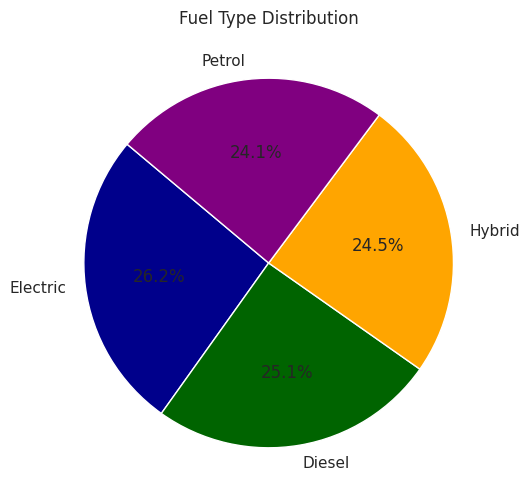

In [245]:
fuel_counts = df["Fuel_Type"].value_counts()
plt.figure(figsize=(6,6))
plt.pie(fuel_counts, labels=fuel_counts.index, autopct='%1.1f%%', startangle=140, colors=["darkblue", "darkgreen", "orange", "purple"])
plt.title("Fuel Type Distribution")
plt.show()

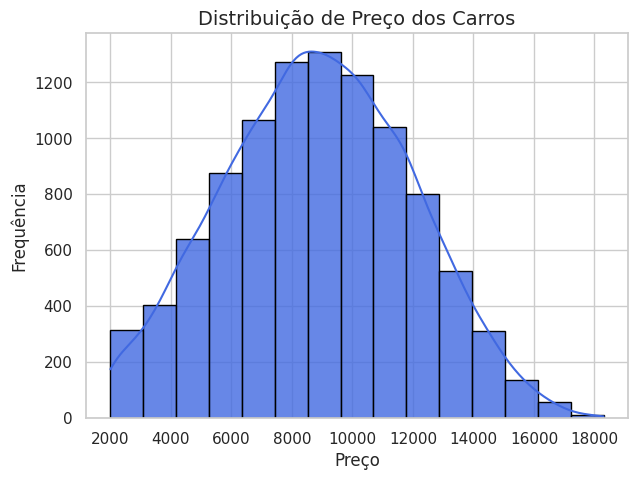

In [246]:
sns.set(style="whitegrid")
plt.figure(figsize=(7,5))
sns.histplot(df["Price"], bins=15, kde=True, color="royalblue", edgecolor="black", alpha=0.8)
plt.xlabel("Preço", fontsize=12)
plt.ylabel("Frequência", fontsize=12)
plt.title("Distribuição de Preço dos Carros", fontsize=14)
plt.show()

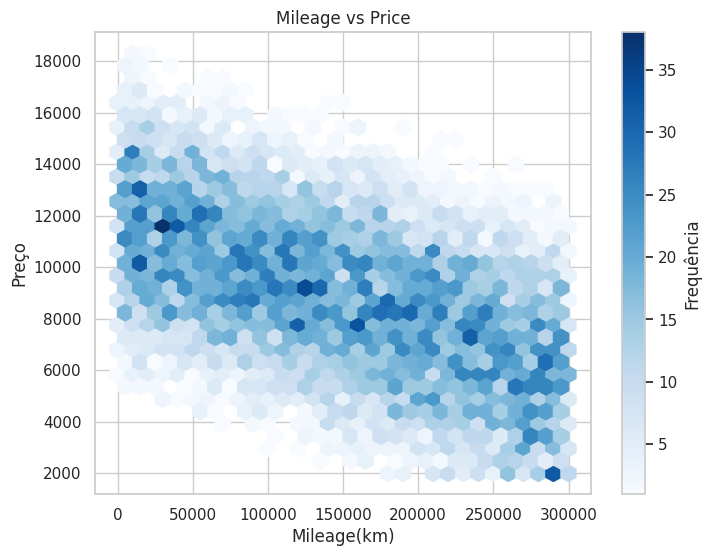

In [247]:
plt.figure(figsize=(8,6))
plt.hexbin(df["Mileage"], df["Price"], gridsize=30, cmap="Blues", mincnt=1)
plt.colorbar(label="Frequência")
plt.xlabel("Mileage(km)")
plt.ylabel("Preço")
plt.title("Mileage vs Price")
plt.show()

### Identificação de variáveis numéricas e categóricas

In [248]:
var_num = df.select_dtypes(include=['number']).columns # Identificando variáveis numéricas
var_ctg = df.select_dtypes(exclude=['number']).columns # Identificando variáveis categóricas

print("Variáveis Numéricas:")
print(var_num)

print("\nVariáveis Categóricas:")
print(var_ctg)

Variáveis Numéricas:
Index(['Year', 'Engine_Size', 'Mileage', 'Doors', 'Owner_Count', 'Price'], dtype='object')

Variáveis Categóricas:
Index(['Brand', 'Model', 'Fuel_Type', 'Transmission'], dtype='object')


### Análise das Variáveis Numéricas

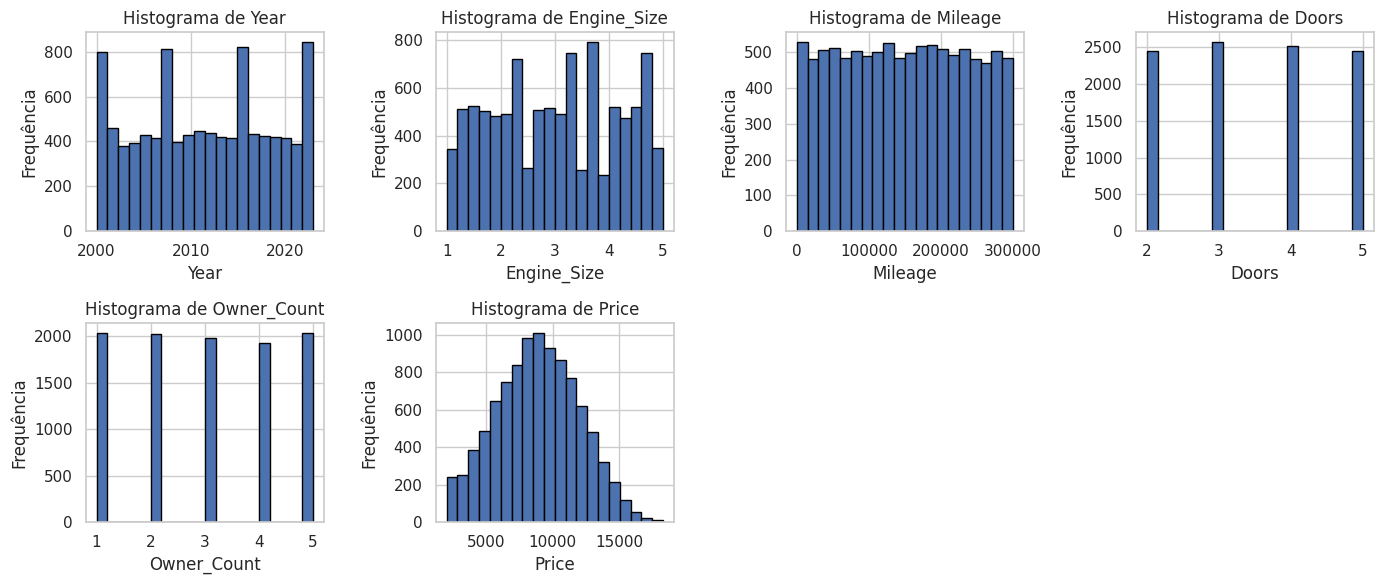

In [249]:
col_num = len(var_num)
linhas_num = math.ceil(col_num / 3)
plt.figure(figsize=(14, linhas_num * 3))

# Criando os histogramas
for i, column in enumerate(var_num, 1):
    plt.subplot(linhas_num, 4, i)
    df[column].hist(bins=20, edgecolor='black')
    plt.title(f'Histograma de {column}')
    plt.xlabel(column)
    plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

### Correlação de Pearson para Variáveis Numéricas

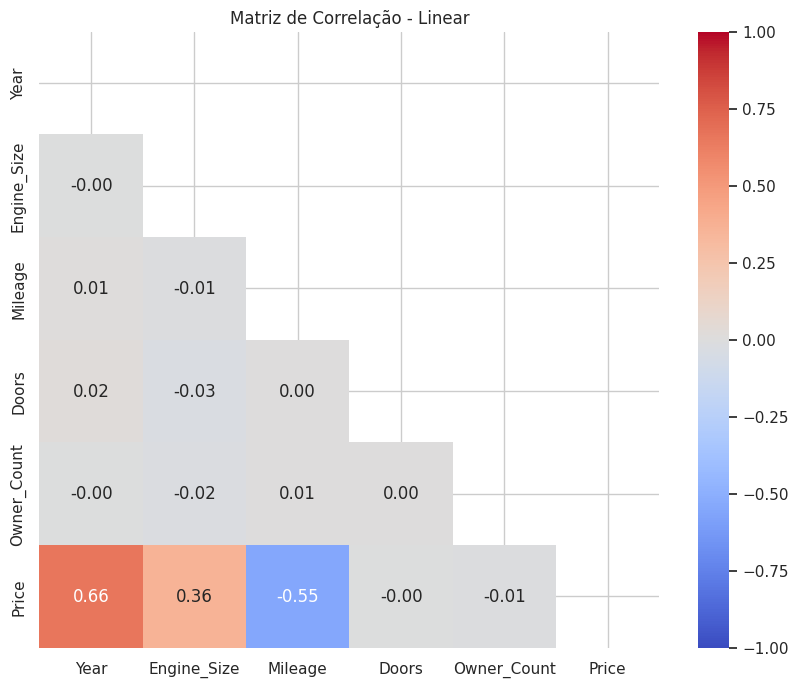

In [250]:
plt.figure(figsize=(10, 8))

correlation_matrix_pearson = df_amostra.corr(method='pearson', numeric_only=True)
mask = np.triu(np.ones_like(correlation_matrix_pearson, dtype=bool))
sns.heatmap(correlation_matrix_pearson, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, vmin=-1, vmax=1)

plt.title('Matriz de Correlação - Linear')
plt.show()

### Análise das Variáveis Categóricas

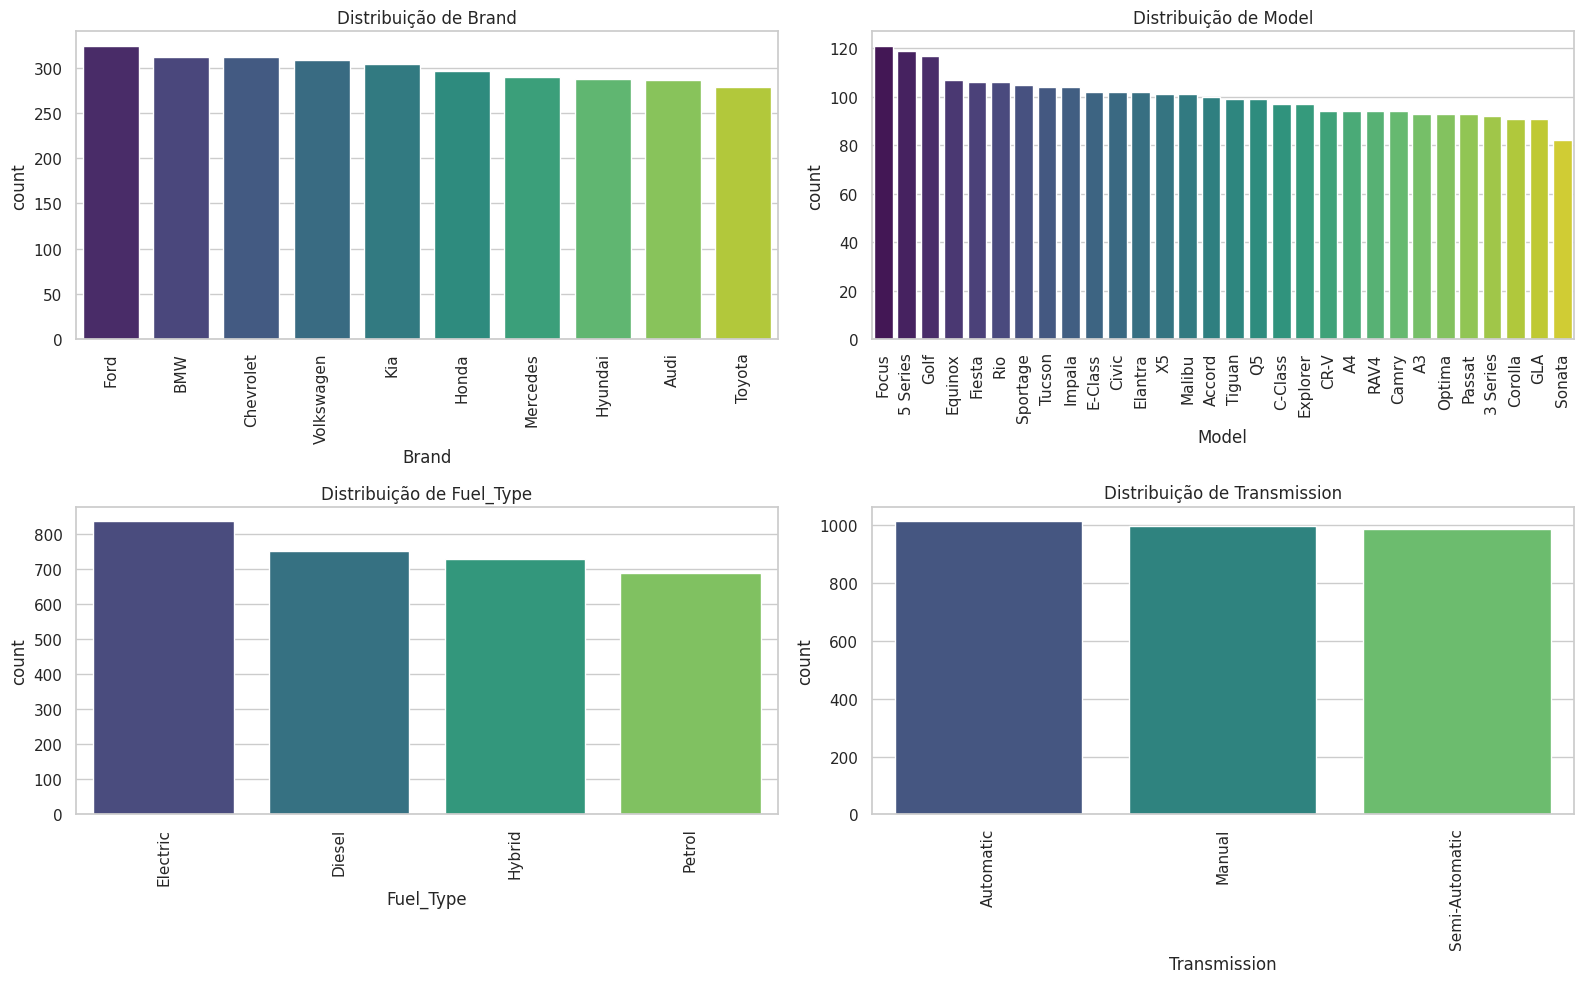

In [251]:
fig, axes = plt.subplots(len(var_ctg) // 2 + len(var_ctg) % 2, 2, figsize=(16, (len(var_ctg) // 2 + len(var_ctg) % 2) * 5))

# Ajustar o eixo para quando a quantidade de gráficos for ímpar
for i, col in enumerate(var_ctg):
    row = i // 2
    col_idx = i % 2
    # Gráfico de barras (contagem de ocorrências)
    sns.countplot(data=df_amostra, x=col, ax=axes[row, col_idx], order=df_amostra[col].value_counts().index, palette="viridis")
    axes[row, col_idx].set_title(f"Distribuição de {col}")
    axes[row, col_idx].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

### Correlação das Variáveis Categóricas

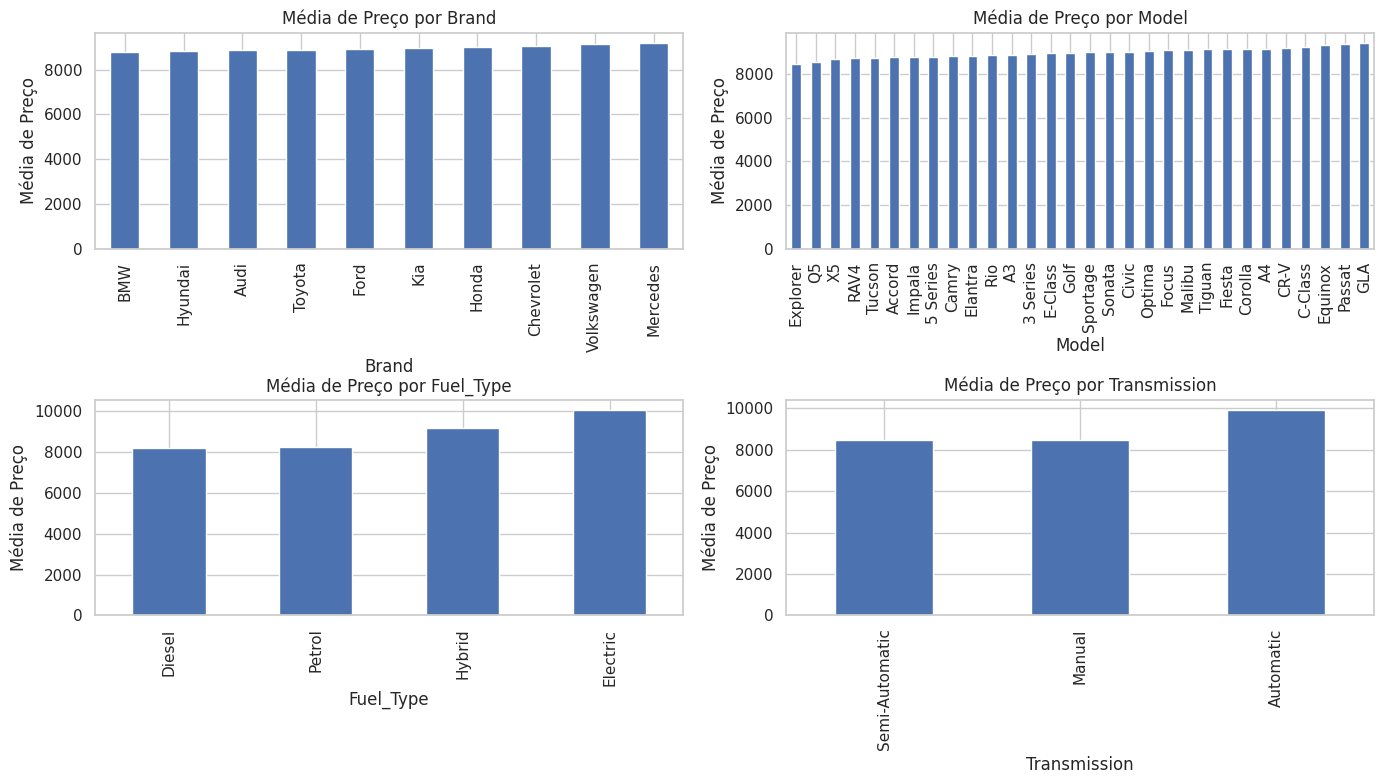

In [252]:
col_num = len(var_ctg)
linhas_num = (col_num // 2)
fig, axes = plt.subplots(linhas_num, 2, figsize=(14, linhas_num * 4))

axes = axes.flatten()

for i, col in enumerate(var_ctg):
    df_amostra.groupby(col)['Price'].mean().sort_values().plot(
        kind='bar', ax=axes[i], title=f'Média de Preço por {col}'
    )
    axes[i].set_ylabel('Média de Preço')
    axes[i].set_xlabel(col)
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.subplots_adjust(hspace=0.7)
plt.show()

#### Teste ANOVA

In [253]:
df_anova = df.copy()
df_anova.head(1)

,Brand,Model,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count,Price
0,Kia,Rio,2020,4.2,Diesel,Manual,289944,3,5,8501


In [254]:
# Loop para realizar a ANOVA para cada variável categórica
for col in var_ctg:

    # Realizando a ANOVA entre a variável categórica e a variável numérica
    grouped_data = [df_anova[df_anova[col] == cat]["Price"] for cat in df_anova[col].unique()]

    # Aplicando a ANOVA
    f_stat, p_val = stats.f_oneway(*grouped_data)

    # Saída dos valores
    print(f"P-valor da ANOVA para {col}: {p_val:.4f}")

P-valor da ANOVA para Brand: 0.1903
P-valor da ANOVA para Model: 0.8178
P-valor da ANOVA para Fuel_Type: 0.0000
P-valor da ANOVA para Transmission: 0.0000


# Modelagem

In [255]:
df.head()

,Brand,Model,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count,Price
0,Kia,Rio,2020,4.2,Diesel,Manual,289944,3,5,8501
1,Chevrolet,Malibu,2012,2.0,Hybrid,Automatic,5356,2,3,12092
2,Mercedes,GLA,2020,4.2,Diesel,Automatic,231440,4,2,11171
3,Audi,Q5,2023,2.0,Electric,Manual,160971,2,1,11780
4,Volkswagen,Golf,2003,2.6,Hybrid,Semi-Automatic,286618,3,3,2867


In [256]:
le = LabelEncoder()
for col in df.select_dtypes(include=["object"]).columns:
    df[col] = le.fit_transform(df[col])

In [257]:
X = df.drop(columns=["Price"])
y = df["Price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [258]:
# Apresentando os valores para cada conjunto dividido
print("X_train:\n", X_train.shape)
print("\nX_test:\n", X_test.shape)
print("\ny_train:\n", y_train.shape)
print("\ny_test:\n", y_test.shape)

X_train:
 (7000, 9)

X_test:
 (3000, 9)

y_train:
 (7000,)

y_test:
 (3000,)


In [259]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7000 entries, 9069 to 7270
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         7000 non-null   int64  
 1   Model         7000 non-null   int64  
 2   Year          7000 non-null   int64  
 3   Engine_Size   7000 non-null   float64
 4   Fuel_Type     7000 non-null   int64  
 5   Transmission  7000 non-null   int64  
 6   Mileage       7000 non-null   int64  
 7   Doors         7000 non-null   int64  
 8   Owner_Count   7000 non-null   int64  
dtypes: float64(1), int64(8)
memory usage: 546.9 KB


- Agora que todas nossas variáveis categóricas já foram convertidas para números e conferidas, podemos assim progredir para a modelagem.

## Normalizar os dados

In [260]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Treinamento de Diversos Modelos

In [261]:
# Lista de modelos que serão usados para o treinamento
modelos = [
    (LinearRegression(), "Linear Regression"),
    (GradientBoostingRegressor(n_estimators=50, max_depth=3, random_state=42), "Gradient Boosting"),
    (RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1), "Random Forest"),
    (XGBRegressor(n_estimators=50, max_depth=6, learning_rate=0.1, random_state=42, verbosity=0), "XGBoost")
]

In [262]:
# Lista para armazenar os resultados
resultados = []

# Função de treinamento e avaliação
def avaliacao_e_treino(model, model_name, X_train, X_test, y_train, y_test):
    # Treinando o modelo
    model.fit(X_train, y_train)

    # Fazendo predições no conjunto de teste
    y_pred = model.predict(X_test)

    # Calculando as métricas de avaliação
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Armazenando os resultados
    resultados.append({
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    })

In [263]:
# Treinar modelos com barra de progresso
for model, model_name in tqdm(modelos, desc="Training Models", unit="model"):
    avaliacao_e_treino(model, model_name, X_train, X_test, y_train, y_test)

# Converter os resultados para um DataFrame
df_resultados = pd.DataFrame(resultados)

# Exibir os resultados
df_resultados

Training Models: 100%|██████████| 4/4 [00:03<00:00,  1.17model/s]


,Model,MAE,RMSE,R2
0,Linear Regression,797.870772,907.792825,0.912360
1,Gradient Boosting,430.067023,538.024492,0.969216
2,Random Forest,486.667680,593.060754,0.962595
3,XGBoost,207.760590,263.082360,0.992639


## Tuning e Métricas do Modelo

In [264]:
# Função para otimizar os hiperparâmetros
def otimizar(trial):
    parametros = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0.1, 1.0)
    }

    # Criar o modelo XGBoost com os parâmetros sugeridos
    model = XGBRegressor(**parametros, random_state=42, verbosity=0)

    # Treinar o modelo com os dados
    model.fit(X_train, y_train)

    # Fazer as predições e calcular o MAE para avaliação
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)

    return mae  # Retornar a métrica que será minimizada

In [265]:
# Rodar a otimização
study = optuna.create_study(direction='minimize')
study.optimize(otimizar, n_trials=10)  # Testa 10 combinações diferentes

[I 2025-02-12 20:16:35,375] A new study created in memory with name: no-name-64ac1d51-7bf8-4235-b0b0-e45f2d66bb31
[I 2025-02-12 20:16:35,956] Trial 0 finished with value: 343.8951721191406 and parameters: {'n_estimators': 61, 'max_depth': 8, 'learning_rate': 0.09563050785180767, 'subsample': 0.8732016903724376, 'colsample_bytree': 0.6057655866757365, 'gamma': 0.33175358433640545}. Best is trial 0 with value: 343.8951721191406.
[I 2025-02-12 20:16:37,460] Trial 1 finished with value: 846.4231567382812 and parameters: {'n_estimators': 84, 'max_depth': 7, 'learning_rate': 0.021064079107055957, 'subsample': 0.6079152726627408, 'colsample_bytree': 0.6710371524905518, 'gamma': 0.6890430028446407}. Best is trial 0 with value: 343.8951721191406.
[I 2025-02-12 20:16:40,195] Trial 2 finished with value: 241.82606506347656 and parameters: {'n_estimators': 66, 'max_depth': 7, 'learning_rate': 0.05703273968298625, 'subsample': 0.6958812070417534, 'colsample_bytree': 0.9493999141244155, 'gamma': 0.4

In [266]:
# Melhor conjunto de hiperparâmetros encontrado
print("Melhores hiperparâmetros:", study.best_params)
print("Melhor MAE:", study.best_value)

Melhores hiperparâmetros: {'n_estimators': 84, 'max_depth': 6, 'learning_rate': 0.07157236908800757, 'subsample': 0.8183479176351274, 'colsample_bytree': 0.9030220160845781, 'gamma': 0.7854644787550091}
Melhor MAE: 169.71951293945312


In [267]:
# Treinando o modelo final com os melhores hiperparâmetros
best_params = study.best_params
final_model = XGBRegressor(**best_params, random_state=42, n_jobs=-1)
final_model.fit(X_train, y_train)

# Avaliação no conjunto de teste
y_test_pred = final_model.predict(X_test)

## Métricas de Avaliação

In [268]:
# Calcular métricas no conjunto de teste
final_mae = mean_absolute_error(y_test, y_test_pred)
final_mse = mean_squared_error(y_test, y_test_pred)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_test, y_test_pred)

# Exibir as métricas
print("Métricas no Conjunto de Teste:")
print(f"MAE  (Mean Absolute Error): {final_mae:.2f}")
print(f"RMSE (Root Mean Squared Error): {final_rmse:.2f}")
print(f"R²   (Coeficiente de Determinação): {final_r2:.4f}")

Métricas no Conjunto de Teste:
MAE  (Mean Absolute Error): 169.72
RMSE (Root Mean Squared Error): 215.58
R²   (Coeficiente de Determinação): 0.9951


## XAI

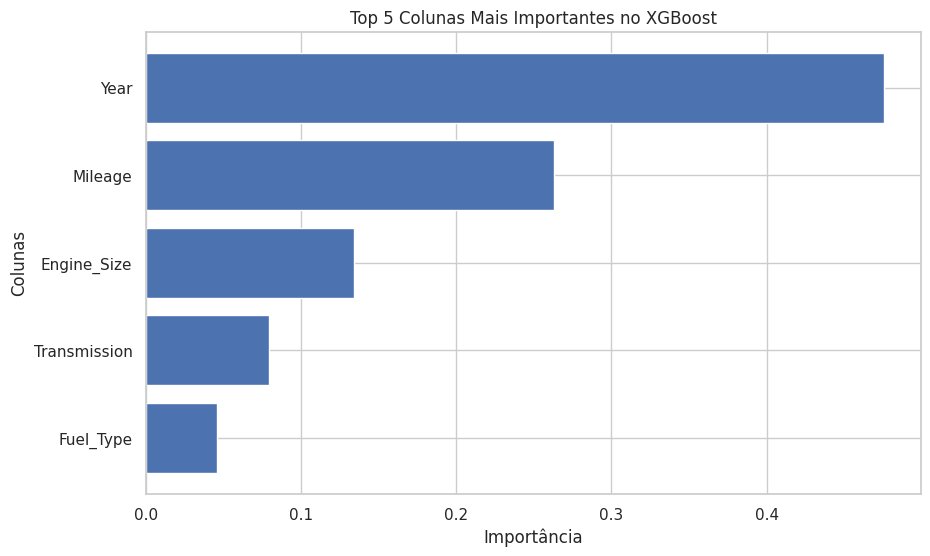

In [269]:
# Obtendo a importância das features do modelo XGBoost
feature_importance = model.feature_importances_

# Garantir que temos os nomes das features originais (após o pré-processamento)
feature_names = X.columns

# DataFrame com as importâncias das features
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)

# Plotar as 5 features mais importantes
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"].head(5), importance_df["Importance"].head(5))
plt.xlabel("Importância")
plt.ylabel("Colunas")
plt.title("Top 5 Colunas Mais Importantes no XGBoost")
plt.gca().invert_yaxis()  # Inverter o eixo Y para exibir a feature mais importante no topo
plt.show()

# FIM